# Test different templates
- use neg control 1 (30% seq id removed from enzymes+ion binding)
- made sure that all templates are found in scan
- for each templates set, run on above test set, remove matches target-template with id >30% only for pos set
- run on AF2 templates

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import subprocess
import re
from typing import Callable
import biotite.structure.io.pdb as pdb
import biotite.structure as struc
import numpy as np

In [2]:
# Utility functions

def saveTemplate(path:str, atom_array, res_type=-1) -> None:
    """
    
        Save into template file using PDB format

        PARAMETERS
        ----------
        path:str path to template;
        atom_array: biotite atom array;
        res_type: int based on Tess paper (doi.org/10.1002%2Fpro.5560061104) {-1: "Template atom", 0: "Search by atom type", 
                                                                              1: "Non-carbon side chain atom", 2: "Non-carbon atom", 
                                                                              3: "Search by specified atom", 4: "Non-carbon main chain atom",
                                                                              5: "Search by any main chain atom", 6: "Search by any side chain atom",
                                                                              7: "Search by any atom type"}
    
    """
    atom_format_string = (
        "%s%7i  %-4s%3s %c%4i    %8.3f%8.3f%8.3f\n"
    )
    with open(path, "w") as fh:
        
        for atom in atom_array:
            j = tuple(["ATOM", res_type, atom.atom_name, atom.res_name, atom.chain_id, atom.res_id, atom.coord[0], atom.coord[1], atom.coord[2]])
            fh.write(atom_format_string % j)

def createTemplates(df:pd.DataFrame, out_templates:str, sub:Callable) -> list:
    """
    

        Create Jess templates

        PARAMETERS
        ----------
        df:pd.DataFrame, data frame storing isopeptide bond formations
        out_templates:str, path to output folder
        sub:Callable, function to subset atoms to be used as templates

        RETURNS
        -------
        used_templates:list, list of used templates
    
    """
    # Create templates
    shutil.rmtree(out_templates)
    os.makedirs(out_templates, exist_ok=True)
    
    # Specify conditions for templates
    
    cond1 = (df["Is bonded"] == True)
    cond2 = (df["Interchain"] == False)
    cond3 = (df["Bad rotamer"] == False)
    cond4 = (df["Residue 1"] == "K")
    cond5 = (df["Residue 2"].isin(["D", "E"]))
    cond6 = (df["Residue 2"].isin(["N", "D", "E"]))
    cond7 = (df["Resolution"]<=2.5)
    cond8 = (df["Unusual geometry/chemistry"]==False)
    
    sub_df = df[cond1 & cond2 & cond3 & cond4 & cond5 & cond7 & cond8]
    
    # Use the same template for all to align
    ref_chain = sub_df.iloc[0]["Chain"]
    ref_pdb = sub_df.iloc[0]["PDB code"]
    ref_r1 = sub_df.iloc[0]["Position 1\r\n(Bond 1)"]
    ref_r2 = sub_df.iloc[0]["Position 2\r\n(catalytic)"]
    ref_r3 = sub_df.iloc[0]["Position 3\r\n(Bond 2)"]
    ref_residues = [ref_r1, ref_r2, ref_r3]
    
    ref_s_path = os.path.join(POSITIVE_DATASET, f"{ref_pdb}_{ref_chain}.pdb")
    pdb_file = pdb.PDBFile.read(ref_s_path)
    ref_s = pdb_file.get_structure()
    # Subset only lys
    ref_template = struc.array([atom for atom in ref_s[0] if atom.res_id == ref_r1])
    used_templates = []
    
    for _, row in sub_df.iterrows():
        chain = row["Chain"]
        pdb_code = row["PDB code"]
        r1 = row["Position 1\r\n(Bond 1)"]
        r2 = row["Position 2\r\n(catalytic)"]
        r3 = row["Position 3\r\n(Bond 2)"]
        s2_path = os.path.join(POSITIVE_DATASET, f"{pdb_code}_{chain}.pdb")
        pdb_file = pdb.PDBFile.read(s2_path) 
        s2 = pdb_file.get_structure() 
        s2_res = [r1, r2, r3]
        out_struct_path = os.path.join(out_templates, f"{pdb_code}_{chain}_{int(r1)}_{int(r2)}_{int(r3)}.pdb")
        s2_sub = struc.array([atom for atom in s2[0] if atom.res_id in s2_res and "H" not in atom.atom_name])
        s2_lys = struc.array([atom for atom in s2[0] if atom.res_id == r1 and "H" not in atom.atom_name])
        s2_t = None
        try:
            _, transformation = struc.superimpose(fixed=ref_template, mobile=s2_lys)
            # Apply transformation based on K to rest of residue
            s2_t = transformation.apply(s2_sub)
            
        except ValueError:
            print(f"Transformation error for: {pdb_code}, number of residues in K {r1} is {len(s2_lys)}, expected: {len(ref_template)}")
            # Skip if no NZ
            if not "NZ" in [atom.atom_name for atom in s2_lys]:
                print("Found no NZ atom, skipping")
                continue
            # Reduce atoms from template cause mobile Lys could have less atoms (usually no N)
            atoms_to_consider = [atom.atom_name for atom in s2_lys]
            ref_template_reduced = struc.array([atom for atom in ref_template if atom.atom_name in atoms_to_consider])
            # Try again
            _, transformation = struc.superimpose(fixed=ref_template_reduced, mobile=s2_lys)
            # Apply transformation based on K to rest of residue
            s2_t = struc.superimpose_apply(s2_sub, transformation)
    
        # Subset
        s2_t = sub(s2_t)
        saveTemplate( out_struct_path, s2_t)
        used_templates.append(out_struct_path)

    return used_templates

def parse(jess_output:str) -> pd.DataFrame():
    """

        Parses Jess raw output from scanning PDB structures into a table ['target', 'rmsd', 'template', 'chain', 'target_residues', 'template_residues']
        Deprecated
    
    """
    # Parse results
    line_to_info = re.compile("REMARK ([a-z/A-Z_0-9.pdb-]{,200}) ([0-9].[0-9]{3}) ([a-z/A-Z_0-9.pdb-]{,200}) Det= [-]{,2}(?:[0-9].[0-9]|nan) log\\(E\\)~([ -]{,2}[0-9]{,3}.[0-9]{2})")
    
    outlist = []
    for line in jess_output.split("\n"):
        
        if line.startswith("REMARK"):
            try:
                match_ = line_to_info.findall(line)[0]
            except IndexError:
                print(line)
            assert len(match_) == 4, f"{match_}"
            target_path = match_[0]
            target = target_path.split("/")[-1].replace(".pdb", "")
            rmsd = float(match_[1])
            template = match_[2].split("/")[-1].replace(".pdb", "")
            loge = float(match_[3].strip())
            sublist = [target, target_path, rmsd, template]
            residues = []
            chain = None
            
        if line.startswith("ATOM"):
            chain = line[21]
            resi = int(line[22:26].strip())
            residues.append(resi)
        
        if line.startswith("ENDMDL"):
            sublist.append(chain)
            sublist.append(set(residues))
            outlist.append(sublist)
            sublist = []
        
    res_df = pd.DataFrame(outlist, columns=['target', 'target_path', 'rmsd', 'template', 'chain', 'target_residues'])
    res_df['template_residues'] = res_df["template"].apply(lambda x: set([int(i) for i in x.split("_")[2:]]))
    res_df['template'] = res_df["template"].apply(lambda x: "_".join(x.split("_")[:2]))
    res_df["target_residues"] = res_df["target_residues"].apply(lambda x: "_".join([str(_) for _ in sorted(x)]))
    res_df["template_residues"] = res_df["template_residues"].apply(lambda x: "_".join([str(_) for _ in sorted(x)]))
    res_df["target_id"] = res_df.apply(lambda x: x["target"].lower().split("_")[0]+"_"+x["chain"].lower()+"_"+x["target_residues"], axis=1)

    return res_df

def overlap(set1, set2):
    """
    
        Get the overlap (in terms of raw counts)
    
    """
    """
    rng = min(set1.min(), set2.min()), max(set1.max(), set2.max())

    hist1, _ = np.histogram(set1, bins=nbins, range=rng)
    hist2, _ = np.histogram(set2, bins=nbins, range=rng)
    return np.sum(np.minimum(hist1, hist2))
    """
    set1_max = set1.max()
    set_2_min = set2.min()
    overlap_ = 0
    # Overlapping entries from set1 if max of set 1 is above min of set 2
    # Overlapping entries from set2 if min of set 2 is below max of set 1
    if set1_max >= set_2_min:
        overlap_ = len([i for i in set1 if i >= set_2_min]) + len([i for i in set2 if i <= set1_max])

    return overlap_

MAX_ASA = { "rost_sander": { "LYS": 205, "ASP": 163, "GLU": 194, "ASN": 157 }}
def getASA(row) -> float:
    """
    
        Calculates rASA of isopep residues. Returns average value. Use mash points == 100 to speed up computation
    
    """
    rASA = np.NaN
    struct_path = row["structure_path"]
    chain = row["chain"]
    r1, r2, r3 = [int(i) for i in row["match_residues"].split("_")]
    pdb_file = pdb.PDBFile.read(struct_path)
    # Exclude water
    structure = struc.array([atom for atom in pdb_file.get_structure()[0] if atom.hetero==False and atom.chain_id==chain])
    # Consider whole structure to calculate sASA
    try:
        structure_sasa = struc.sasa(structure, point_number=500)
        # Get indeces
        r1_indx = [i for i, atom in enumerate(structure) if atom.res_id == r1]
        r2_indx = [i for i, atom in enumerate(structure) if atom.res_id == r2]
        r3_indx = [i for i, atom in enumerate(structure) if atom.res_id == r3]

        r1_aa = structure[r1_indx[0]].res_name
        r2_aa = structure[r2_indx[0]].res_name
        r3_aa = structure[r3_indx[0]].res_name
        
        r1_asa = sum([structure_sasa[i] for i in r1_indx]) / MAX_ASA["rost_sander"][r1_aa]
        r2_asa = sum([structure_sasa[i] for i in r2_indx]) / MAX_ASA["rost_sander"][r2_aa]
        r3_asa = sum([structure_sasa[i] for i in r3_indx]) / MAX_ASA["rost_sander"][r3_aa]
        
        rASA = [r1_asa, r2_asa, r3_asa]
        
    except IndexError:
        ""
        rASA = np.NaN
        
    except KeyError:
        rASA = np.NaN

    return rASA

In [3]:
from dotenv import load_dotenv
load_dotenv("../../.env")
JESS = os.getenv("JESS")
NEGATIVE_DATASET = os.getenv("NEGATIVE_CONTROL_3")+"_training"
POSITIVE_DATASET = os.getenv("POSITIVE_CONTROL")
TABLE = os.getenv("TABLE")
POSITIVE_CONTROL_IDENTITIES = os.getenv("POSITIVE_CONTROL_IDENTITIES")
INPUT_STRUCTURES_FILES = "output/structures"
AF2_POS_SET = os.getenv("AF2_POS_SET")
AF2_POS_SET_TEMPLATES = os.getenv("AF2_POS_SET_TEMPLATES")
AF2_BIOCHEM = os.getenv("AF2_BIOCHEM")
AF2_TEMPLATES_BIOCHEM = os.getenv("AF2_TEMPLATES_BIOCHEM")

In [4]:
df = pd.read_csv(TABLE)
df["id"] = df.apply(lambda x: f"{x['PDB code']}_"+
                    x["Chain"]+"_"+"_".join( 
                        [str(i) for i in sorted(
                            [
                            x["Position 1\r\n(Bond 1)"],
                            x["Position 2\r\n(catalytic)"],
                            x["Position 3\r\n(Bond 2)"]
                            ]
                            )]
                            ), axis=1)

# Get all vs all identities
# Wehere coming from?
identity_df = pd.read_csv(POSITIVE_CONTROL_IDENTITIES)
# Make it reciprocal
identity_df = pd.concat([identity_df, identity_df.rename(columns={"Query":"Target", "Target":"Query"})])
identity_df["Query"] = identity_df["Query"].apply(lambda x: x.lower())
identity_df["Target"] = identity_df["Target"].apply(lambda x: x.lower())
identity_df = identity_df.drop_duplicates()

In [5]:
# Create input structures file
with open(INPUT_STRUCTURES_FILES, "w") as fh:
    for neg_file in os.listdir(NEGATIVE_DATASET):   
        if neg_file.split(".")[-1] != "pdb":
            continue
        # Verify no negative files overlap with positive dataset
        if neg_file.split("/")[-1].replace(".pdb", "").lower() in df["PDB code"].unique():
            print(neg_file)
            continue
        fh.write(os.path.join(NEGATIVE_DATASET, neg_file)+"\n")
    for pos_file in os.listdir(POSITIVE_DATASET):
        if pos_file.split(".")[-1] != "pdb":
            continue
        fh.write(os.path.join(POSITIVE_DATASET, pos_file)+"\n")


## Set 1

In [9]:
SET = "set1"
templates_file = f"output/templates/{SET}/templates"

In [11]:
def subsetAtoms(atom_array):
    """
    
        Subset atoms from atom array
    
    """
    subset = []
    for atom in atom_array:
        
        if atom.res_name == "ASP":
            if atom.atom_name == "OD1":
                subset.append(atom)
            elif atom.atom_name == "OD2":
                subset.append(atom)
                
        elif atom.res_name == "ASN":
            if atom.atom_name == "OD1":
                subset.append(atom)
            elif atom.atom_name == "ND2":
                subset.append(atom)
                
        elif atom.res_name == "GLU":
            if atom.atom_name == "OE1":
                subset.append(atom)
            elif atom.atom_name == "OE2":
                subset.append(atom)
        
        elif atom.res_name == "LYS":
            if atom.atom_name == "NZ":
                subset.append(atom)

    return struc.array(subset)

In [12]:
templates_path = f"output/templates/{SET}"
os.makedirs(templates_path, exist_ok=True)
used_templates = createTemplates(df=df, out_templates=templates_path, sub=subsetAtoms)

In [ ]:
with open(templates_file, "w") as fh:
    for file in used_templates:
        fh.write(f"{file}\n")

In [13]:
# Distance must be 1.5*RMSD
cache_table = f"output/{SET}_cached.csv"
if not os.path.exists(cache_table):
    distance=5
    rmsd_threshold, distance_cutoff, max_allowed_distance = [str(distance)]*3
    cmd = [str(JESS), str(templates_file), str(INPUT_STRUCTURES_FILES), rmsd_threshold, distance_cutoff, max_allowed_distance]
    
    process = subprocess.Popen(
        cmd, text=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE
    )
    stdout, stderr = process.communicate()
    res_df = parse(stdout)
    res_df.to_csv(cache_table, index=False)
else:
    res_df = pd.read_csv(cache_table)

In [14]:
res_df["true_positive"] = 0
templates = df["id"].str.lower().unique()
res_df.loc[res_df["target_id"].isin(templates), "true_positive"] = 1
res_df["template_id"] = res_df.apply(lambda x: x["template"].lower()+"_"+x["template_residues"], axis=1)

In [15]:
# Consider only matches with identity < 30 (apply only to positive set)
# Exclude self matches
plot_df = pd.merge(res_df, identity_df[identity_df["identity"]>0.3].rename(columns={"Query":"target_id", "Target":"template_id"})\
        .assign(allowed=0), on=["target_id", "template_id"], how="left").fillna(1)\
        .query('allowed==1').query('target_id!=template_id')
# Exclude some entries:
to_exclude = df[(df["Bad rotamer"])|(df["Interchain"])|(~df["Is bonded"])|(df["Unusual geometry/chemistry"])]["id"].str.lower().to_list()
plot_df = plot_df[~plot_df["target_id"].isin(to_exclude)]
# Remove duplicated entries from template-target inversion and only after this remove rmsd-duplicates
plot_df["merged_id"] = plot_df.apply(lambda x: "-".join(sorted([x["target_id"], x["template_id"]])), axis=1)
plot_df = plot_df.drop_duplicates("merged_id")\
        .sort_values("rmsd").drop_duplicates(["target", "target_residues"], keep="first")

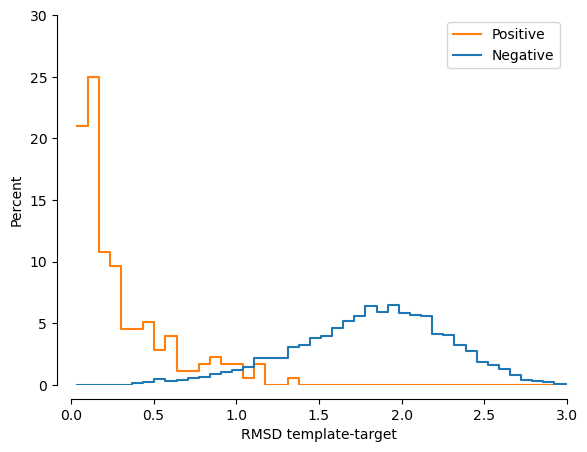

In [23]:
fig, ax = plt.subplots()

sns.histplot(plot_df, x="rmsd", hue="true_positive", fill=False, element="step", common_norm=False, stat="percent", ax=ax)
sns.despine(offset=10, ax=ax)
ax.legend(title="", labels=["Positive", "Negative"])
ax.set_xlim([0, 3])
ax.set_ylim([0, 30])

ax.set_xlabel("RMSD template-target")

plt.savefig("../../tmp/set1.png", dpi=400, transparent=True, bbox_inches="tight")

In [17]:
overlap(plot_df[plot_df["true_positive"]==1]["rmsd"],
       plot_df[plot_df["true_positive"]==0]["rmsd"])

1063

## Set 2

In [29]:
SET = "set2"
templates_file = f"output/templates/{SET}/templates"

In [16]:
# Create templates
def subsetAtoms(atom_array):
    """
    
        Subset atoms from atom array
    
    """
    subset = []
    for atom in atom_array:
        
        if atom.res_name == "ASP":
            if atom.atom_name == "OD1":
                subset.append(atom)
            elif atom.atom_name == "OD2":
                subset.append(atom)
            elif atom.atom_name == "CG":
                subset.append(atom)
                
        elif atom.res_name == "ASN":
            if atom.atom_name == "OD1":
                subset.append(atom)
            elif atom.atom_name == "ND2":
                subset.append(atom)
            elif atom.atom_name == "CG":
                subset.append(atom)
                
        elif atom.res_name == "GLU":
            if atom.atom_name == "OE1":
                subset.append(atom)
            elif atom.atom_name == "OE2":
                subset.append(atom)
            elif atom.atom_name == "CD":
                subset.append(atom)
        
        elif atom.res_name == "LYS":
            if atom.atom_name == "NZ":
                subset.append(atom)
            elif atom.atom_name == "CE":
                subset.append(atom)

    return struc.array(subset)

In [17]:
templates_path = f"output/templates/{SET}"
os.makedirs(templates_path, exist_ok=True)
used_templates = createTemplates(df=df, out_templates=templates_path, sub=subsetAtoms)

In [18]:
templates_file = f"output/templates/{SET}/templates"
with open(templates_file, "w") as fh:
    for file in used_templates:
        fh.write(f"{file}\n")

In [30]:
# Distance must be 1.5*RMSD
cache_table = f"output/{SET}_cached.csv"
if not os.path.exists(cache_table):
    distance=5
    rmsd_threshold, distance_cutoff, max_allowed_distance = [str(distance)]*3
    cmd = [str(JESS), str(templates_file), str(INPUT_STRUCTURES_FILES), rmsd_threshold, distance_cutoff, max_allowed_distance]
    
    process = subprocess.Popen(
        cmd, text=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE
    )
    stdout, stderr = process.communicate()
    res_df = parse(stdout)
    res_df.to_csv(cache_table, index=False)
else:
    res_df = pd.read_csv(cache_table)

In [31]:
res_df["true_positive"] = 0
templates = df["id"].str.lower().unique()
res_df.loc[res_df["target_id"].isin(templates), "true_positive"] = 1
res_df["template_id"] = res_df.apply(lambda x: x["template"].lower()+"_"+x["template_residues"], axis=1)

In [32]:
# Consider only matches with identity < 30 (apply only to positive set)
# Exclude self matches
plot_df = pd.merge(res_df, identity_df[identity_df["identity"]>0.3].rename(columns={"Query":"target_id", "Target":"template_id"})\
        .assign(allowed=0), on=["target_id", "template_id"], how="left").fillna(1)\
        .query('allowed==1').query('target_id!=template_id')
# Exclude some entries:
to_exclude = df[(df["Bad rotamer"])|(df["Interchain"])|(~df["Is bonded"])|(df["Unusual geometry/chemistry"])]["id"].str.lower().to_list()
plot_df = plot_df[~plot_df["target_id"].isin(to_exclude)]
# Remove duplicated entries from template-target inversion and only after this remove rmsd-duplicates
plot_df["merged_id"] = plot_df.apply(lambda x: "-".join(sorted([x["target_id"], x["template_id"]])), axis=1)
plot_df = plot_df.drop_duplicates("merged_id")\
        .sort_values("rmsd").drop_duplicates(["target", "target_residues"], keep="first")

<Axes: xlabel='rmsd', ylabel='Percent'>

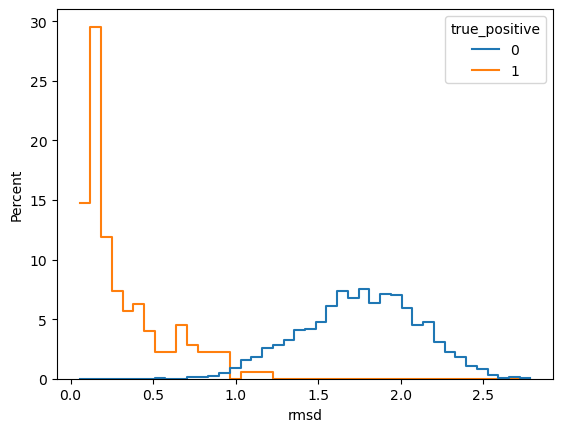

In [33]:
sns.histplot(plot_df, x="rmsd", hue="true_positive", fill=False, element="step", common_norm=False, stat="percent")

In [34]:
overlap(plot_df[plot_df["true_positive"]==1]["rmsd"],
       plot_df[plot_df["true_positive"]==0]["rmsd"])

262

## Set 4

In [24]:
SET = "set4"
templates_file = f"output/templates/{SET}/templates"

In [36]:
def subsetAtoms(atom_array):
    """
    
        Subset atoms from atom array
    
    """
    subset = []
    for atom in atom_array:
        
        if atom.res_name == "ASP":
            if atom.atom_name == "CA":
                subset.append(atom)
            elif atom.atom_name == "CB":
                subset.append(atom)
            elif atom.atom_name == "CG":
                subset.append(atom)
                
        elif atom.res_name == "ASN":
            if atom.atom_name == "CA":
                subset.append(atom)
            elif atom.atom_name == "CB":
                subset.append(atom)
            elif atom.atom_name == "CG":
                subset.append(atom)
                
        elif atom.res_name == "GLU":
            if atom.atom_name == "CB":
                subset.append(atom)
            elif atom.atom_name == "CG":
                subset.append(atom)
            elif atom.atom_name == "CD":
                subset.append(atom)
        
        elif atom.res_name == "LYS":
            if atom.atom_name == "CG":
                subset.append(atom)
            elif atom.atom_name == "CD":
                subset.append(atom)
            elif atom.atom_name == "CE":
                subset.append(atom)

    return struc.array(subset)

In [96]:
templates_path = f"output/templates/{SET}"
os.makedirs(templates_path, exist_ok=True)
used_templates = createTemplates(df=df, out_templates=templates_path, sub=subsetAtoms)

In [27]:
templates_file = f"output/templates/{SET}/templates"
with open(templates_file, "w") as fh:
    for file in used_templates:
        fh.write(f"{file}\n")

In [25]:
# Distance must be 1.5*RMSD
cache_table = f"output/{SET}_cached.csv"
if not os.path.exists(cache_table):
    distance=5
    rmsd_threshold, distance_cutoff, max_allowed_distance = [str(distance)]*3
    cmd = [str(JESS), str(templates_file), str(INPUT_STRUCTURES_FILES), rmsd_threshold, distance_cutoff, max_allowed_distance]
    
    process = subprocess.Popen(
        cmd, text=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE
    )
    stdout, stderr = process.communicate()
    res_df = parse(stdout)
    res_df.to_csv(cache_table, index=False)
else:
    res_df = pd.read_csv(cache_table)

In [26]:
res_df["true_positive"] = 0
templates = df["id"].str.lower().unique()
res_df.loc[res_df["target_id"].isin(templates), "true_positive"] = 1
res_df["template_id"] = res_df.apply(lambda x: x["template"].lower()+"_"+x["template_residues"], axis=1)

In [27]:
# Consider only matches with identity < 30 (apply only to positive set)
# Exclude self matches
plot_df = pd.merge(res_df, identity_df[identity_df["identity"]>0.3].rename(columns={"Query":"target_id", "Target":"template_id"})\
        .assign(allowed=0), on=["target_id", "template_id"], how="left").fillna(1)\
        .query('allowed==1').query('target_id!=template_id')
# Exclude some entries:
to_exclude = df[(df["Bad rotamer"])|(df["Interchain"])|(~df["Is bonded"])|(df["Unusual geometry/chemistry"])]["id"].str.lower().to_list()
plot_df = plot_df[~plot_df["target_id"].isin(to_exclude)]
# Remove duplicated entries from template-target inversion and only after this remove rmsd-duplicates
plot_df["merged_id"] = plot_df.apply(lambda x: "-".join(sorted([x["target_id"], x["template_id"]])), axis=1)
plot_df = plot_df.drop_duplicates("merged_id")\
        .sort_values("rmsd").drop_duplicates(["target", "target_residues"], keep="first")

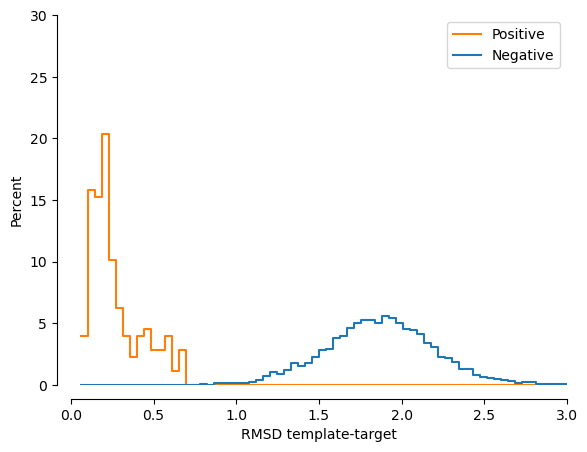

In [28]:
fig, ax = plt.subplots()

sns.histplot(plot_df, x="rmsd", hue="true_positive", fill=False, element="step", common_norm=False, stat="percent", ax=ax)
sns.despine(offset=10, ax=ax)
ax.legend(title="", labels=["Positive", "Negative"])
ax.set_xlim([0, 3])
ax.set_ylim([0, 30])

ax.set_xlabel("RMSD template-target")

plt.savefig("../../tmp/set4.png", dpi=400, transparent=True, bbox_inches="tight")

In [41]:
overlap(plot_df[plot_df["true_positive"]==1]["rmsd"],
       plot_df[plot_df["true_positive"]==0]["rmsd"])

0

## Set 5

In [42]:
SET = "set5"
templates_file = f"output/templates/{SET}/templates"

In [34]:
def subsetAtoms(atom_array):
    """
    
        Subset atoms from atom array
    
    """
    subset = []
    for atom in atom_array:
        
        if atom.res_name == "ASP":
            if atom.atom_name == "CB":
                subset.append(atom)
            elif atom.atom_name == "CG":
                subset.append(atom)
                
        elif atom.res_name == "ASN":
            if atom.atom_name == "CB":
                subset.append(atom)
            elif atom.atom_name == "CG":
                subset.append(atom)
                
        elif atom.res_name == "GLU":
            if atom.atom_name == "CG":
                subset.append(atom)
            elif atom.atom_name == "CD":
                subset.append(atom)
        
        elif atom.res_name == "LYS":
            if atom.atom_name == "CD":
                subset.append(atom)
            elif atom.atom_name == "CE":
                subset.append(atom)

    return struc.array(subset)

In [35]:
templates_path = f"output/templates/{SET}"
os.makedirs(templates_path, exist_ok=True)
used_templates = createTemplates(df=df, out_templates=templates_path, sub=subsetAtoms)

In [36]:
templates_file = f"output/templates/{SET}/templates"
with open(templates_file, "w") as fh:
    for file in used_templates:
        fh.write(f"{file}\n")

In [43]:
# Distance must be 1.5*RMSD
cache_table = f"output/{SET}_cached.csv"
if not os.path.exists(cache_table):
    distance=5
    rmsd_threshold, distance_cutoff, max_allowed_distance = [str(distance)]*3
    cmd = [str(JESS), str(templates_file), str(INPUT_STRUCTURES_FILES), rmsd_threshold, distance_cutoff, max_allowed_distance]
    
    process = subprocess.Popen(
        cmd, text=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE
    )
    stdout, stderr = process.communicate()
    res_df = parse(stdout)
    res_df.to_csv(cache_table, index=False)
else:
    res_df = pd.read_csv(cache_table)

In [44]:
res_df["true_positive"] = 0
templates = df["id"].str.lower().unique()
res_df.loc[res_df["target_id"].isin(templates), "true_positive"] = 1
res_df["template_id"] = res_df.apply(lambda x: x["template"].lower()+"_"+x["template_residues"], axis=1)

In [45]:
# Consider only matches with identity < 30 (apply only to positive set)
# Exclude self matches
plot_df = pd.merge(res_df, identity_df[identity_df["identity"]>0.3].rename(columns={"Query":"target_id", "Target":"template_id"})\
        .assign(allowed=0), on=["target_id", "template_id"], how="left").fillna(1)\
        .query('allowed==1').query('target_id!=template_id')
# Exclude some entries:
to_exclude = df[(df["Bad rotamer"])|(df["Interchain"])|(~df["Is bonded"])|(df["Unusual geometry/chemistry"])]["id"].str.lower().to_list()
plot_df = plot_df[~plot_df["target_id"].isin(to_exclude)]
# Remove duplicated entries from template-target inversion and only after this remove rmsd-duplicates
plot_df["merged_id"] = plot_df.apply(lambda x: "-".join(sorted([x["target_id"], x["template_id"]])), axis=1)
plot_df = plot_df.drop_duplicates("merged_id")\
        .sort_values("rmsd").drop_duplicates(["target", "target_residues"], keep="first")

<Axes: xlabel='rmsd', ylabel='Percent'>

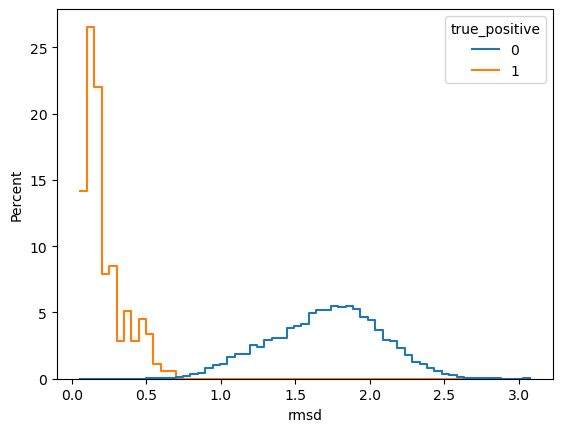

In [46]:
sns.histplot(plot_df, x="rmsd", hue="true_positive", fill=False, element="step", common_norm=False, stat="percent")

In [47]:
overlap(plot_df[plot_df["true_positive"]==1]["rmsd"],
       plot_df[plot_df["true_positive"]==0]["rmsd"])

17

## Set 6

In [48]:
SET = "set6"
templates_file = f"output/templates/{SET}/templates"

In [43]:
def subsetAtoms(atom_array):
    """
    
        Subset atoms from atom array
    
    """
    subset = []
    for atom in atom_array:
        
        if atom.res_name == "ASP":
            if atom.atom_name == "CA":
                subset.append(atom)
            elif atom.atom_name == "CB":
                subset.append(atom)
                
        elif atom.res_name == "ASN":
            if atom.atom_name == "CA":
                subset.append(atom)
            elif atom.atom_name == "CB":
                subset.append(atom)
                
        elif atom.res_name == "GLU":
            if atom.atom_name == "CA":
                subset.append(atom)
            elif atom.atom_name == "CG":
                subset.append(atom)
        
        elif atom.res_name == "LYS":
            if atom.atom_name == "CG":
                subset.append(atom)
            elif atom.atom_name == "CD":
                subset.append(atom)

    return struc.array(subset)

In [44]:
templates_path = f"output/templates/{SET}"
os.makedirs(templates_path, exist_ok=True)
used_templates = createTemplates(df=df, out_templates=templates_path, sub=subsetAtoms)

In [45]:
templates_file = f"output/templates/{SET}/templates"
with open(templates_file, "w") as fh:
    for file in used_templates:
        fh.write(f"{file}\n")

In [49]:
# Distance must be 1.5*RMSD
cache_table = f"output/{SET}_cached.csv"
if not os.path.exists(cache_table):
    distance=5
    rmsd_threshold, distance_cutoff, max_allowed_distance = [str(distance)]*3
    cmd = [str(JESS), str(templates_file), str(INPUT_STRUCTURES_FILES), rmsd_threshold, distance_cutoff, max_allowed_distance]
    
    process = subprocess.Popen(
        cmd, text=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE
    )
    stdout, stderr = process.communicate()
    res_df = parse(stdout)
    res_df.to_csv(cache_table, index=False)
else:
    res_df = pd.read_csv(cache_table)

In [50]:
res_df["true_positive"] = 0
templates = df["id"].str.lower().unique()
res_df.loc[res_df["target_id"].isin(templates), "true_positive"] = 1
res_df["template_id"] = res_df.apply(lambda x: x["template"].lower()+"_"+x["template_residues"], axis=1)

In [51]:
# Consider only matches with identity < 30 (apply only to positive set)
# Exclude self matches
plot_df = pd.merge(res_df, identity_df[identity_df["identity"]>0.3].rename(columns={"Query":"target_id", "Target":"template_id"})\
        .assign(allowed=0), on=["target_id", "template_id"], how="left").fillna(1)\
        .query('allowed==1').query('target_id!=template_id')
# Exclude some entries:
to_exclude = df[(df["Bad rotamer"])|(df["Interchain"])|(~df["Is bonded"])|(df["Unusual geometry/chemistry"])]["id"].str.lower().to_list()
plot_df = plot_df[~plot_df["target_id"].isin(to_exclude)]
# Remove duplicated entries from template-target inversion and only after this remove rmsd-duplicates
plot_df["merged_id"] = plot_df.apply(lambda x: "-".join(sorted([x["target_id"], x["template_id"]])), axis=1)
plot_df = plot_df.drop_duplicates("merged_id")\
        .sort_values("rmsd").drop_duplicates(["target", "target_residues"], keep="first")

<Axes: xlabel='rmsd', ylabel='Percent'>

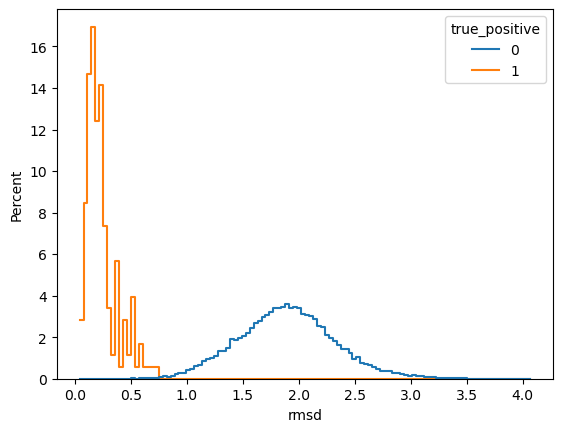

In [52]:
sns.histplot(plot_df, x="rmsd", hue="true_positive", fill=False, element="step", common_norm=False, stat="percent")

In [53]:
overlap(plot_df[plot_df["true_positive"]==1]["rmsd"],
       plot_df[plot_df["true_positive"]==0]["rmsd"])

82

## Set 7

In [54]:
SET = "set7"
templates_file = f"output/templates/{SET}/templates"

In [55]:
def subsetAtoms(atom_array):
    """
    
        Subset atoms from atom array
    
    """
    subset = []
    for atom in atom_array:
        
        if atom.res_name == "ASP":
            if atom.atom_name == "CA":
                subset.append(atom)
            elif atom.atom_name == "CG":
                subset.append(atom)
                
        elif atom.res_name == "ASN":
            if atom.atom_name == "CA":
                subset.append(atom)
            elif atom.atom_name == "CG":
                subset.append(atom)
                
        elif atom.res_name == "GLU":
            if atom.atom_name == "CB":
                subset.append(atom)
            elif atom.atom_name == "CD":
                subset.append(atom)
        
        elif atom.res_name == "LYS":
            if atom.atom_name == "CG":
                subset.append(atom)
            elif atom.atom_name == "CE":
                subset.append(atom)

    return struc.array(subset)

In [119]:
templates_path = f"output/templates/{SET}"
os.makedirs(templates_path, exist_ok=True)
used_templates = createTemplates(df=df, out_templates=templates_path, sub=subsetAtoms)

In [120]:
templates_file = f"output/templates/{SET}/templates"
with open(templates_file, "w") as fh:
    for file in used_templates:
        fh.write(f"{file}\n")

In [56]:
# Distance must be 1.5*RMSD
cache_table = f"output/{SET}_cached.csv"
if not os.path.exists(cache_table):
    distance=5
    rmsd_threshold, distance_cutoff, max_allowed_distance = [str(distance)]*3
    cmd = [str(JESS), str(templates_file), str(INPUT_STRUCTURES_FILES), rmsd_threshold, distance_cutoff, max_allowed_distance]
    
    process = subprocess.Popen(
        cmd, text=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE
    )
    stdout, stderr = process.communicate()
    res_df = parse(stdout)
    res_df.to_csv(cache_table, index=False)
else:
    res_df = pd.read_csv(cache_table)

In [57]:
res_df["true_positive"] = 0
templates = df["id"].str.lower().unique()
res_df.loc[res_df["target_id"].isin(templates), "true_positive"] = 1
res_df["template_id"] = res_df.apply(lambda x: x["template"].lower()+"_"+x["template_residues"], axis=1)

In [58]:
# Consider only matches with identity < 30 (apply only to positive set)
# Exclude self matches
plot_df = pd.merge(res_df, identity_df[identity_df["identity"]>0.3].rename(columns={"Query":"target_id", "Target":"template_id"})\
        .assign(allowed=0), on=["target_id", "template_id"], how="left").fillna(1)\
        .query('allowed==1').query('target_id!=template_id')
# Exclude some entries:
to_exclude = df[(df["Bad rotamer"])|(df["Interchain"])|(~df["Is bonded"])|(df["Unusual geometry/chemistry"])]["id"].str.lower().to_list()
plot_df = plot_df[~plot_df["target_id"].isin(to_exclude)]
# Remove duplicated entries from template-target inversion and only after this remove rmsd-duplicates
plot_df["merged_id"] = plot_df.apply(lambda x: "-".join(sorted([x["target_id"], x["template_id"]])), axis=1)
plot_df = plot_df.drop_duplicates("merged_id")\
        .sort_values("rmsd").drop_duplicates(["target", "target_residues"], keep="first")

<Axes: xlabel='rmsd', ylabel='Percent'>

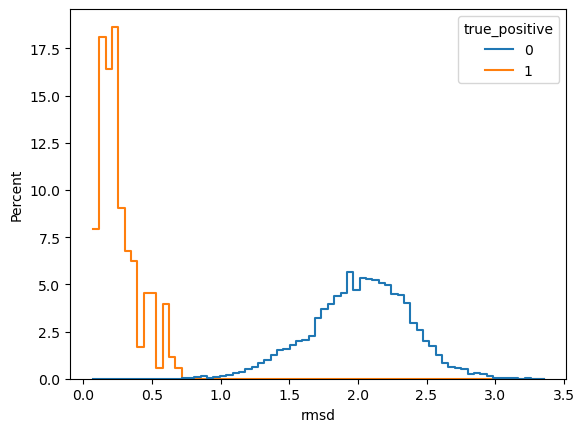

In [59]:
sns.histplot(plot_df, x="rmsd", hue="true_positive", fill=False, element="step", common_norm=False, stat="percent")

In [60]:
overlap(plot_df[plot_df["true_positive"]==1]["rmsd"],
       plot_df[plot_df["true_positive"]==0]["rmsd"])

2

## Set 8

This set consists of set 4 atoms but allowing asn/asp at second bond position
and glu/asp at catalyitic position. Allow also search by atom type.

In [35]:
cond1 = (df["Is bonded"] == True)
cond2 = (df["Interchain"] == False)
cond3 = (df["Isopeptide type"] != "Mutant")
    
df[cond1 & cond2 & cond3].value_counts(["Residue 2", "Residue 3"])

Residue 2  Residue 3
E          N            93
D          N            72
E          D            22
A          N             1
S          N             1
Name: count, dtype: int64

In [11]:
def createTemplates(df:pd.DataFrame, out_templates:str, sub:Callable) -> list:
    """
    

        Create Jess templates

        PARAMETERS
        ----------
        df:pd.DataFrame, data frame storing isopeptide bond formations
        out_templates:str, path to output folder
        sub:Callable, function to subset atoms to be used as templates

        RETURNS
        -------
        used_templates:list, list of used templates
    
    """
    # Create templates
    shutil.rmtree(out_templates)
    os.makedirs(out_templates, exist_ok=True)
    
    # Specify conditions for templates
    
    cond1 = (df["Is bonded"] == True)
    cond2 = (df["Interchain"] == False)
    cond3 = (df["Bad rotamer"] == False)
    cond4 = (df["Isopeptide type"] != "Mutant")
    cond5 = (df["Resolution"]<=2.5)
    cond6 = (df["Unusual geometry/chemistry"]==False)
    
    sub_df = df[cond1 & cond2 & cond3 & cond4 & cond5 & cond6]
    
    # Use the same template for all to align
    ref_chain = sub_df.iloc[0]["Chain"]
    ref_pdb = sub_df.iloc[0]["PDB code"]
    ref_r1 = sub_df.iloc[0]["Position 1\r\n(Bond 1)"]
    ref_r2 = sub_df.iloc[0]["Position 2\r\n(catalytic)"]
    ref_r3 = sub_df.iloc[0]["Position 3\r\n(Bond 2)"]
    ref_residues = [ref_r1, ref_r2, ref_r3]
    
    ref_s_path = os.path.join(POSITIVE_DATASET, f"{ref_pdb}_{ref_chain}.pdb")
    pdb_file = pdb.PDBFile.read(ref_s_path)
    ref_s = pdb_file.get_structure()
    # Subset only lys
    ref_template = struc.array([atom for atom in ref_s[0] if atom.res_id == ref_r1])
    used_templates = []
    
    for _, row in sub_df.iterrows():
        chain = row["Chain"]
        pdb_code = row["PDB code"]
        r1 = row["Position 1\r\n(Bond 1)"]
        r2 = row["Position 2\r\n(catalytic)"]
        r3 = row["Position 3\r\n(Bond 2)"]
        s2_path = os.path.join(POSITIVE_DATASET, f"{pdb_code}_{chain}.pdb")
        pdb_file = pdb.PDBFile.read(s2_path) 
        s2 = pdb_file.get_structure() 
        s2_res = [r1, r2, r3]
        out_struct_path = os.path.join(out_templates, f"{pdb_code}_{chain}_{int(r1)}_{int(r2)}_{int(r3)}.pdb")
        s2_sub = struc.array([atom for atom in s2[0] if atom.res_id in s2_res and "H" not in atom.atom_name])
        s2_lys = struc.array([atom for atom in s2[0] if atom.res_id == r1 and "H" not in atom.atom_name])
        s2_t = None
        try:
            _, transformation = struc.superimpose(fixed=ref_template, mobile=s2_lys)
            # Apply transformation based on K to rest of residue
            s2_t = transformation.apply(s2_sub)
            
        except ValueError:
            print(f"Transformation error for: {pdb_code}, number of residues in K {r1} is {len(s2_lys)}, expected: {len(ref_template)}")
            # Skip if no NZ
            if not "NZ" in [atom.atom_name for atom in s2_lys]:
                print("Found no NZ atom, skipping")
                continue
            # Reduce atoms from template cause mobile Lys could have less atoms (usually no N)
            atoms_to_consider = [atom.atom_name for atom in s2_lys]
            ref_template_reduced = struc.array([atom for atom in ref_template if atom.atom_name in atoms_to_consider])
            # Try again
            _, transformation = struc.superimpose(fixed=ref_template_reduced, mobile=s2_lys)
            # Apply transformation based on K to rest of residue
            s2_t = struc.superimpose_apply(s2_sub, transformation)
    
        # Subset
        s2_t = sub(s2_t)
        # Res type == 0 means "Search by atom type"
        res_type = 0
        atom_format_string = (
            "%s%7i  %-4s%3s %c%4i    %8.3f%8.3f%8.3f  %s\n"
        )
        with open(out_struct_path, "w") as fh:
            
            for atom in s2_t:
                if atom.res_id == r2:
                    j = tuple(
                        [
                            "ATOM", res_type, atom.atom_name, atom.res_name,
                            atom.chain_id, atom.res_id, atom.coord[0], atom.coord[1], atom.coord[2], 
                            "DE" # Consider these amino acids
                        ]
                    )
                elif atom.res_id == r3:
                    j = tuple(
                        [
                            "ATOM", res_type, atom.atom_name, atom.res_name,
                            atom.chain_id, atom.res_id, atom.coord[0], atom.coord[1], atom.coord[2], 
                            "ND" # Consider these amino acids
                        ]
                    )
                else:
                    j = tuple(
                        [
                            "ATOM", res_type, atom.atom_name, atom.res_name,
                            atom.chain_id, atom.res_id, atom.coord[0], atom.coord[1], atom.coord[2], 
                            "K" # Consider these amino acids
                        ]
                    )
                
                fh.write(atom_format_string % j)
        
        used_templates.append(out_struct_path)

    return used_templates

def subsetAtoms(atom_array):
    """
    
        Subset atoms from atom array
    
    """
    subset = []
    for atom in atom_array:
        
        if atom.res_name == "ASP":
            if atom.atom_name == "CA":
                subset.append(atom)
            elif atom.atom_name == "CB":
                subset.append(atom)
            elif atom.atom_name == "CG":
                subset.append(atom)
                
        elif atom.res_name == "ASN":
            if atom.atom_name == "CA":
                subset.append(atom)
            elif atom.atom_name == "CB":
                subset.append(atom)
            elif atom.atom_name == "CG":
                subset.append(atom)
                
        elif atom.res_name == "GLU":
            if atom.atom_name == "CB":
                subset.append(atom)
            elif atom.atom_name == "CG":
                subset.append(atom)
            elif atom.atom_name == "CD":
                subset.append(atom)
        
        elif atom.res_name == "LYS":
            if atom.atom_name == "CG":
                subset.append(atom)
            elif atom.atom_name == "CD":
                subset.append(atom)
            elif atom.atom_name == "CE":
                subset.append(atom)

    return struc.array(subset)

In [12]:
SET = "set8"
templates_file = f"output/templates/{SET}/templates"

In [13]:
templates_path = f"output/templates/{SET}"
os.makedirs(templates_path, exist_ok=True)
used_templates = createTemplates(df=df, out_templates=templates_path, sub=subsetAtoms)

In [14]:
templates_file = f"output/templates/{SET}/templates"
with open(templates_file, "w") as fh:
    for file in used_templates:
        fh.write(f"{file}\n")

In [29]:
# Distance must be 1.5*RMSD
cache_table = f"output/{SET}_cached.csv"
if not os.path.exists(cache_table):
    distance=3
    rmsd_threshold, distance_cutoff, max_allowed_distance = [str(distance)]*3
    cmd = [str(JESS), str(templates_file), str(INPUT_STRUCTURES_FILES), rmsd_threshold, distance_cutoff, max_allowed_distance]
    
    process = subprocess.Popen(
        cmd, text=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE
    )
    stdout, stderr = process.communicate()
    res_df = parse(stdout)
    res_df.to_csv(cache_table, index=False)
else:
    res_df = pd.read_csv(cache_table)

In [30]:
res_df["true_positive"] = 0
templates = df["id"].str.lower().unique()
res_df.loc[res_df["target_id"].isin(templates), "true_positive"] = 1
res_df["template_id"] = res_df.apply(lambda x: x["template"].lower()+"_"+x["template_residues"], axis=1)

In [31]:
# Consider only matches with identity < 30 (apply only to positive set)
# Exclude self matches
plot_df = pd.merge(res_df, identity_df[identity_df["identity"]>0.3].rename(columns={"Query":"target_id", "Target":"template_id"})\
        .assign(allowed=0), on=["target_id", "template_id"], how="left").fillna(1)\
        .query('allowed==1').query('target_id!=template_id')
# Exclude some entries:
to_exclude = df[(df["Bad rotamer"])|(df["Interchain"])|(~df["Is bonded"])|(df["Unusual geometry/chemistry"])]["id"].str.lower().to_list()
plot_df = plot_df[~plot_df["target_id"].isin(to_exclude)]
# Remove duplicated entries from template-target inversion and only after this remove rmsd-duplicates
plot_df["merged_id"] = plot_df.apply(lambda x: "-".join(sorted([x["target_id"], x["template_id"]])), axis=1)
plot_df = plot_df.drop_duplicates("merged_id")\
        .sort_values("rmsd").drop_duplicates(["target", "target_residues"], keep="first")

Text(0.5, 0, 'RMSD template-target')

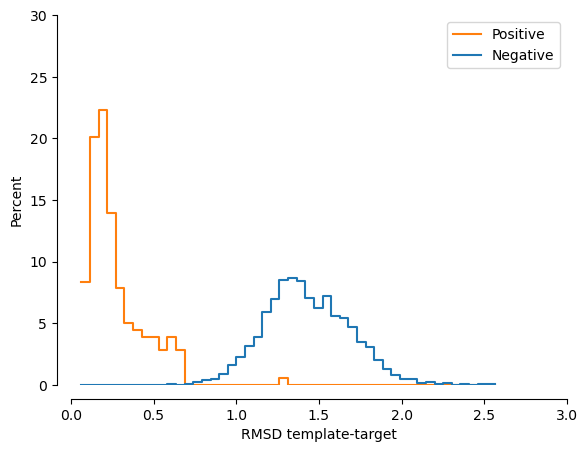

In [32]:
fig, ax = plt.subplots()

sns.histplot(plot_df, x="rmsd", hue="true_positive", fill=False, element="step", common_norm=False, stat="percent", ax=ax)
sns.despine(offset=10, ax=ax)
ax.legend(title="", labels=["Positive", "Negative"])
ax.set_xlim([0, 3])
ax.set_ylim([0, 30])

ax.set_xlabel("RMSD template-target")

In [36]:
overlap(plot_df[plot_df["true_positive"]==1]["rmsd"],
       plot_df[plot_df["true_positive"]==0]["rmsd"])

834

In [38]:
plot_df[plot_df["true_positive"]==0]

,target,target_path,rmsd,template,chain,target_residues,template_residues,target_id,true_positive,template_id,identity,allowed,merged_id
244525,2x9x_A,/nfs/research/agb/research/francesco/projects/...,0.628,2x9z_A,A,192_194_208,193_241_318,2x9x_a_192_194_208,0,2x9z_a_193_241_318,1.0,1.0,2x9x_a_192_194_208-2x9z_a_193_241_318
9948,1I24,1I24,0.712,3gle_A,A,99_142_189,179_258_303,1i24_a_99_142_189,0,3gle_a_179_258_303,1.0,1.0,1i24_a_99_142_189-3gle_a_179_258_303
255496,3rpk_A,/nfs/research/agb/research/francesco/projects/...,0.737,4uzg_A,A,192_194_208,187_225_330,3rpk_a_192_194_208,0,4uzg_a_187_225_330,1.0,1.0,3rpk_a_192_194_208-4uzg_a_187_225_330
228795,2y1v_A,/nfs/research/agb/research/francesco/projects/...,0.751,2x9y_A,A,192_194_208,193_241_318,2y1v_a_192_194_208,0,2x9y_a_193_241_318,1.0,1.0,2x9y_a_193_241_318-2y1v_a_192_194_208
3738,5RKZ,5RKZ,0.754,6m48_A,A,2_4_276,108_395_470,5rkz_a_2_4_276,0,6m48_a_108_395_470,1.0,1.0,5rkz_a_2_4_276-6m48_a_108_395_470
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92497,7PXY,7PXY,2.287,3qe5_A,A,403_404_427,1338_1387_1473,7pxy_a_403_404_427,0,3qe5_a_1338_1387_1473,1.0,1.0,3qe5_a_1338_1387_1473-7pxy_a_403_404_427
51022,6D7A,6D7A,2.302,3qe5_A,A,1008_1064_1072,1338_1387_1473,6d7a_a_1008_1064_1072,0,3qe5_a_1338_1387_1473,1.0,1.0,3qe5_a_1338_1387_1473-6d7a_a_1008_1064_1072
162702,6L61,6L61,2.394,3qe5_A,A,294_296_323,1161_1211_1311,6l61_a_294_296_323,0,3qe5_a_1161_1211_1311,1.0,1.0,3qe5_a_1161_1211_1311-6l61_a_294_296_323
77808,3D1P,3D1P,2.499,5yu5_A,A,40_89_92,186_242_337,3d1p_a_40_89_92,0,5yu5_a_186_242_337,1.0,1.0,3d1p_a_40_89_92-5yu5_a_186_242_337
